#**Recurrent NNs for Time Series Forecasting**

Download our weather forecasting dataset...

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-03-29 02:44:12--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.177.108, 3.5.24.82, 54.231.192.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.177.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  48.4MB/s    in 0.3s    

2025-03-29 02:44:13 (48.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Import the dataset...

In [2]:
import pandas as pd

df = pd.read_csv("jena_climate_2009_2016.csv") # Read in the CSV file.

temperature = df['T (degC)'].to_numpy() # Take the temperature column out.
raw_data = df.drop(labels=['Date Time'],axis=1) # Keep everything minus Date/Time, for use as predictors)

raw_data.head() # This includes T (degC)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Plot the temperature time series...

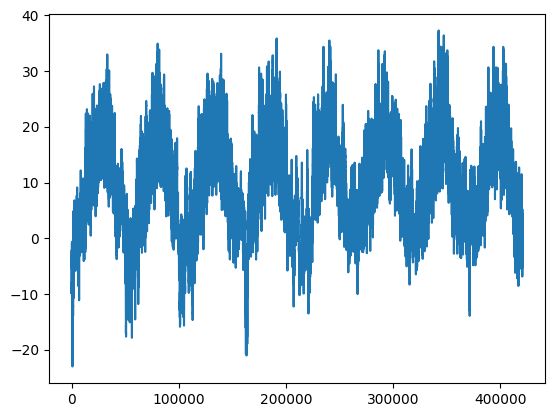

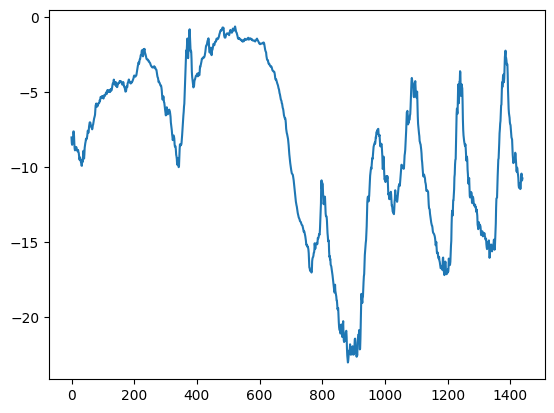

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)),temperature)
plt.show()

plt.plot(range(1440),temperature[:1440])
plt.show()

In [4]:
num_train_samples = int(0.5 * len(temperature)) # First 50% of the temperature series.
num_val_samples = int(0.25 * len(temperature)) # Next 25% of the series.
num_test_samples = len(temperature) - num_train_samples - num_val_samples # Last 25% of the series.
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
import numpy as np

means = np.mean(raw_data,axis=0)
raw_data = np.subtract(raw_data,means)

stds = np.std(raw_data,axis=0)
raw_data = np.divide(raw_data,stds)

print(means)

p (mbar)            989.212508
T (degC)              9.448567
Tpot (K)            283.491182
Tdew (degC)           4.954011
rh (%)               76.007045
VPmax (mbar)         13.575089
VPact (mbar)          9.532524
VPdef (mbar)          4.042483
sh (g/kg)             6.021630
H2OC (mmol/mol)       9.638982
rho (g/m**3)       1216.069883
wv (m/s)              2.130309
max. wv (m/s)         3.532381
wd (deg)            174.726164
dtype: float64


#*Create TF Time Series Datasets*

This example will use tensorflow Dataset pipelines. In subsequent examples we will look at how you can work without these.

In [24]:
from tensorflow import keras

sampling_rate = 6 # The raw data has 6 measurements per hour; we will just use the first.
sequence_length = 120 # A given observation will include a 120 hour history of measurements (5 days)

# Delay = 6 * (120 + 24 - 1) = 143 * 6 = 858
# Delay length is our sequence length (in hours), plus a day. We multiply by 6 because there are 6 obs per hour in the data.
delay = sampling_rate * (sequence_length + 24 - 1) # Our predictions will be 24 hours beyond the end of our sequence.

# We are going to work with 256 such series / sequences and associated targets at a time.
batch_size = 256

# We are going to build the first training dataset using obs 0 up to 210,225 through
# Predictor data comes first, and will run up to 210,225 - 858 (we need to truncate early so we don't try to predict values beyond the end of the observation window.)
print(temperature[:num_train_samples-delay].shape)

# Shuffle means that values appearing in two adjacent sequence observations in the batch are not sequential in time.
# Note that using a tensorflow Dataset here means we don't have to create many redundant / overlapping copies of temperature time series / predictors in memory.
# We will make a generator that pulls these series as needed, on demand.
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# Same thing but using next 25% of samples.
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# And the last 25% for test.
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

(209367,)


In [7]:
# We end up with 256 sequences of 120 hourly observations of 14 features, plus a target temperature that takes place 24 hours post.
for samples, targets in train_dataset:
     print("samples shape:", samples.shape)
     print("targets shape:", targets.shape)
     #print(samples[122,-1,1] * stds[1] + means[1])
     break

samples shape: (256, 120, 14)
targets shape: (256,)


#*Simple Benchmark: Prediction Using a 24 Hour Lag*

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. # Start with 0 running error.
    samples_seen = 0 # Keep track of evaluated samples, so we an average later.
    for samples, targets in dataset:

        # The index [:, -1, 1] means all rows, the last measurement, the second column, i.e., T (degC). So, for every observation, we are grabbing the last obs of temperature in the training sequence.
        # Q: what are the multiplication and addition doing?
        preds = samples[:, -1, 1] * stds[1] + means[1] # samples[:,-1,1] means all sequences, the last observed value, for the second feature (Temp)

        # Running abs error is absolute delta on predicted minus actual. We sum across all such errors in the batch.
        total_abs_err += np.sum(np.abs(preds - targets))

        # We update our running total of predictions.
        samples_seen += samples.shape[0]

    # Lastly, take the average of all those absolute errors and return it.
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset)}")
print(f"Test MAE: {evaluate_naive_method(test_dataset)}")

<ipython-input-8-cef62ffdc0d6>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = samples[:, -1, 1] * stds[1] + means[1] # samples[:,-1,1] means all sequences, the last observed value, for the second feature (Temp)


Validation MAE: 2.4417326002413833
Test MAE: 2.6220358888180635


We can produce one off visual predictions based on this simple benchmark... re-running this code will iterate through the training data and show predictions and actuals.

<ipython-input-11-974560c478e5>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  series = x[0,:,1] * stds[1] + means[1]
<ipython-input-11-974560c478e5>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = x[0,-1,1] * stds[1] + means[1]


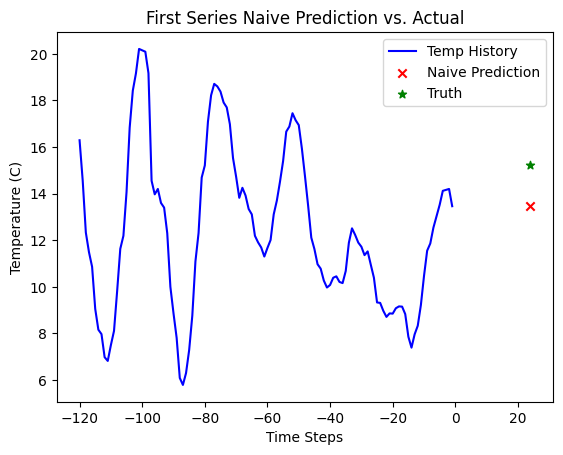

In [11]:
train_seqs = train_dataset.take(1)
for x,y in train_seqs:
  series = x[0,:,1] * stds[1] + means[1]
  pred = x[0,-1,1] * stds[1] + means[1]

  plt.title('First Series Naive Prediction vs. Actual')
  plt.xlabel('Time Steps')
  plt.ylabel('Temperature (C)')
  plt.plot(range(-120,0),series,c="b")
  plt.scatter(24,pred,c="r",marker="x")
  plt.scatter(24,y[0],c="g",marker="*")
  plt.legend(['Temp History','Naive Prediction','Truth'])
  plt.show()
  break

#*Basic Densely Connected Network*

In [58]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Reshape((-1, raw_data.shape[1]))(inputs)  # Reshape to (batch_size, sequence_length, feature count)
flatten = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(flatten)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]


In [59]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 19.3135 - mae: 3.3163 - val_loss: 11.6270 - val_mae: 2.7056
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 9.2612 - mae: 2.3954 - val_loss: 11.1335 - val_mae: 2.6565
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 8.5051 - mae: 2.2980 - val_loss: 16.8630 - val_mae: 3.2997
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 8.0963 - mae: 2.2399 - val_loss: 11.6939 - val_mae: 2.7183
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 7.7360 - mae: 2.1892 - val_loss: 11.4011 - val_mae: 2.6817
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 11.5350 - mae: 2.6782
Test MAE: 2.6809115409851074


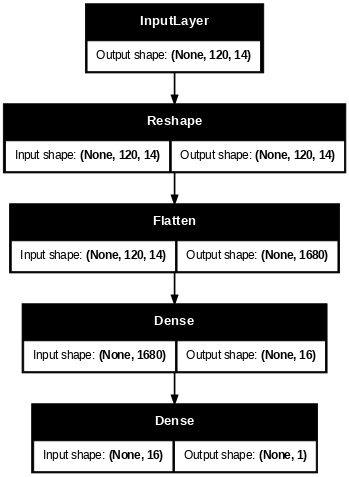

In [56]:
keras.utils.plot_model(model,show_shapes=True,dpi=60)

Let's plot loss over training - our model appears incapable of learning much that is useful.

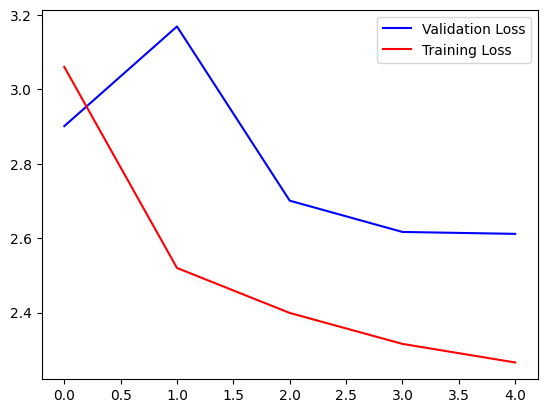

In [57]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

#*CNN Using 1D Convolutions*

Just as a 2D Convolution Preserves Spatial Arrangements of pixel values, the 1D convolution preserves temporal arrangements of time series values. Instead of width and height, it focuses on a single dimension (time). This is useful if we expect generalizable, repeating patterns to appear across time series. Using a 1D Convolution with pooling layers, we can try to learn low-level intertemporal features that aggregate into higher-level temporal patterns that are perhaps useful for forecasting.

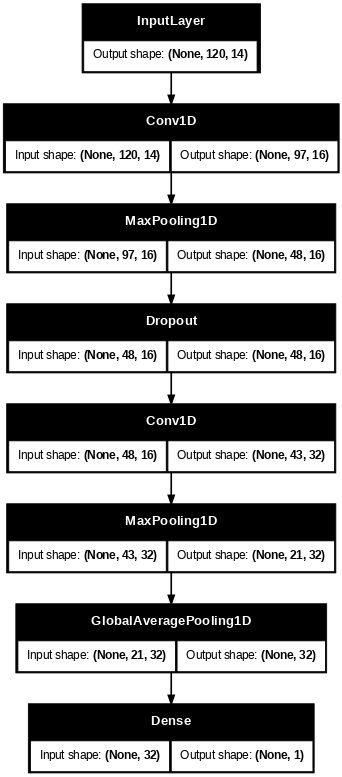

In [69]:
# Recall that we start off with 120 observations of 14 channels (predictors)
# The Conv1D 'compresses' the 120x14 time series vectors into a lower-level embedding.
# Note that 120 - 23 = 97 (the sliding window with no padding means we can only do 97 operations with our filter.
# Output will be compressed signal length x number of kernels / filters, i.e., 97 x 8, for the first Convolution.
# Note: We can't cleanly divide by 2 so we end up with 48 elements in each of our 8 feature maps after the first MaxPool.

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Dropout(0.5)(x) # Then 32 filters, window of 12.
x = layers.Conv1D(16, 24, activation="relu")(inputs) # 1D Convolution with 16 channels / filters, and a window length of 24 (kernel size). Stride here is 1, no padding.
x = layers.MaxPooling1D(2)(x) # Then we apply max pooling, with window of 2 (and stride of 2)
x = layers.Dropout(0.5)(x) # Then 32 filters, window of 12.
x = layers.Conv1D(32, 6, activation="relu")(x) # Then 32 filters, window of 12.
x = layers.MaxPooling1D(2)(x) # Pool by blocks of two values in each sequence (again, means we attempt to divide sequence length in half)
x = layers.GlobalAveragePooling1D()(x) # We apply global average pooling to the resulting 32 feature maps (i.e., what high level patterns were more or less present across the series)
outputs = layers.Dense(1)(x) # Linear activation output.
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
keras.utils.plot_model(model,show_shapes=True,dpi=60)

Let's try fitting this CNN:

In [70]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 27.3343 - mae: 4.0528 - val_loss: 19.0250 - val_mae: 3.4047
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 17.2924 - mae: 3.2975 - val_loss: 15.5354 - val_mae: 3.0878
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 15.7309 - mae: 3.1404 - val_loss: 17.1668 - val_mae: 3.2524
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.8399 - mae: 3.0447 - val_loss: 15.4033 - val_mae: 3.0655
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.2501 - mae: 2.9871 - val_loss: 21.9143 - val_mae: 3.6954
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 13.9298 - mae: 2.9460 - val_loss: 22.6173 - val_mae: 3.7638
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 13.5696 - mae: 2.9084 - val_loss: 17.0027 - val_mae: 3.2577
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 13.2787 - mae: 2.8800 - val_loss: 25.9674 - val_mae: 4.0498
Epoch 9/10
819/819 ━━━━━━━━━━━━

Let's plot the resulting loss over training / validation. It performs pretty badly, because there are no 'persistent' patterns to learn here that generalize across different time windows. Essentially, the patterns in temperature variation differ across particular times of the day. The model is also unable to account for the fact that recent values should receive greater weight / attention than older values when making our prediction! And, the pooling steps are throwing out sequence information.  

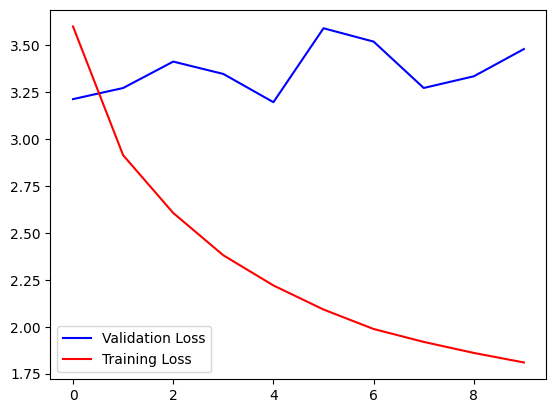

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

#*RNN Using LSTM*

We will start off fitting LSTM, and then come back and look at the architecture.

In [71]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(3,return_sequences=True)(inputs)
x = layers.LSTM(3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 125.1419 - mae: 9.1357 - val_loss: 77.4085 - val_mae: 6.8909
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 67.9133 - mae: 6.3771 - val_loss: 45.9409 - val_mae: 5.1216
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 41.2991 - mae: 4.8311 - val_loss: 26.9555 - val_mae: 3.8526
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 24.5563 - mae: 3.6876 - val_loss: 16.7195 - val_mae: 3.0394
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 16.0961 - mae: 3.0356 - val_loss: 11.8900 - val_mae: 2.6029
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 12.5062 - mae: 2.7285 - val_loss: 10.0332 - val_mae: 2.4397
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 11.1858 - mae: 2.6020 - val_loss: 9.4559 - val_mae: 2.3842
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 10.7015 - mae: 2.5492 - val_loss: 9.2337 - val_mae: 2.3597
Epoch 9/20
819/819 ━━━━━━

Once again, we can plot the validation loss over training:

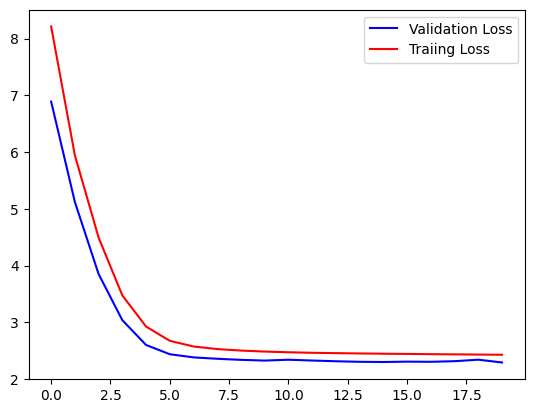

In [72]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Traiing Loss'])
plt.show()

#*Adding Recurrent Dropout or Regularizers*

The recurrent dropout is not implemented in a way that plays nicely with NVIDIA GPUs, so be aware that this model will train pretty slowly. A kernel regularizer may be preferable to mitigate overfitting, if it works.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(32,kernel_regularizer="l2")(inputs)# recurrent_dropout=0.25,unroll=True)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

And let's visualize the loss over training once more...

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

Dropouts successfully mitigates overfitting, so now we can complicate the network by adding more filters / kernels, or by stacking more recurrent layers on top. To do the former, we need to pass the entire sequence of outputs from one layer to the next (return_sequences=True).

#*Stacked Recurrent Layers*

This model will get the MAE down to ~2.3 degrees, but it takes substantial time to train!

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.GRU(32, return_sequences=True, kernel_regularizer="l1_l2")(inputs)# recurrent_dropout=0.5)(inputs)
x = layers.GRU(32, kernel_regularizer="l1_l2")(x)# recurrent_dropout=0.5)(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Let's once again plot the loss over training.

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Traiing Loss'])
plt.show()